In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
import seaborn as sns
import plotly.express as px

from scipy.special import boxcox1p
from scipy.stats import skew

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import explained_variance_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

In [2]:
plt.style.use('ggplot')
sns.set(style='darkgrid')

## Data Cleaning & Merging

In [3]:
df_feat = pd.read_csv('features.csv')
df_feat.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [4]:
df_stores = pd.read_csv('stores.csv')
df_stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [5]:
df_train = pd.read_csv('train.csv')
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [6]:
df_feat.isna().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

In [7]:
mark_list = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
df_feat["CPI"] = df_feat['CPI'].fillna(np.nanmean(df_feat['CPI'].unique()))
df_feat["Unemployment"] = df_feat['Unemployment'].fillna(np.nanmean(df_feat['Unemployment'].unique()))
df_feat[mark_list] = df_feat[mark_list].fillna(0)

In [8]:
df_feat.isna().sum()

Store           0
Date            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday       0
dtype: int64

In [9]:
df_stores.isna().sum()

Store    0
Type     0
Size     0
dtype: int64

In [10]:
df_train.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [11]:
df1 = pd.merge(df_feat, df_stores, on='Store')
df1.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,False,A,151315


In [12]:
df = pd.merge(df1, df_train, on=['Store', 'Date', 'IsHoliday'])
df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales
0,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,A,151315,1,24924.50
1,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,A,151315,2,50605.27
2,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,A,151315,3,13740.12
3,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,A,151315,4,39954.04
4,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,A,151315,5,32229.38


In [13]:
df['Date'] = pd.to_datetime(df['Date'])

In [14]:
df.dtypes

Store                    int64
Date            datetime64[ns]
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
IsHoliday                 bool
Type                    object
Size                     int64
Dept                     int64
Weekly_Sales           float64
dtype: object

In [15]:
df.isna().sum()

Store           0
Date            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday       0
Type            0
Size            0
Dept            0
Weekly_Sales    0
dtype: int64

In [16]:
df.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,136727.915739,44.260317,15981.258123
std,12.785297,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,60980.583328,30.492054,22711.183519
min,1.000000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000,1.000000,-4988.940000
25%,11.000000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000,18.000000,2079.650000
50%,22.000000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,140167.000000,37.000000,7612.030000
75%,33.000000,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,202505.000000,74.000000,20205.852500
max,45.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000,99.000000,693099.360000


In [17]:
df.to_csv('Full_Walmart_Data_After_Cleaning.csv', index=False)

In [18]:
df['Date'].dt.weekday_name.unique()

array(['Friday'], dtype=object)

In [19]:
# Feature Addition
df['Month'] = df.Date.dt.month
df['Day'] = df.Date.dt.day
df['Year'] = df.Date.dt.year
df['Week'] = df.Date.dt.week

In [20]:
df.duplicated().sum()

0

## EDA

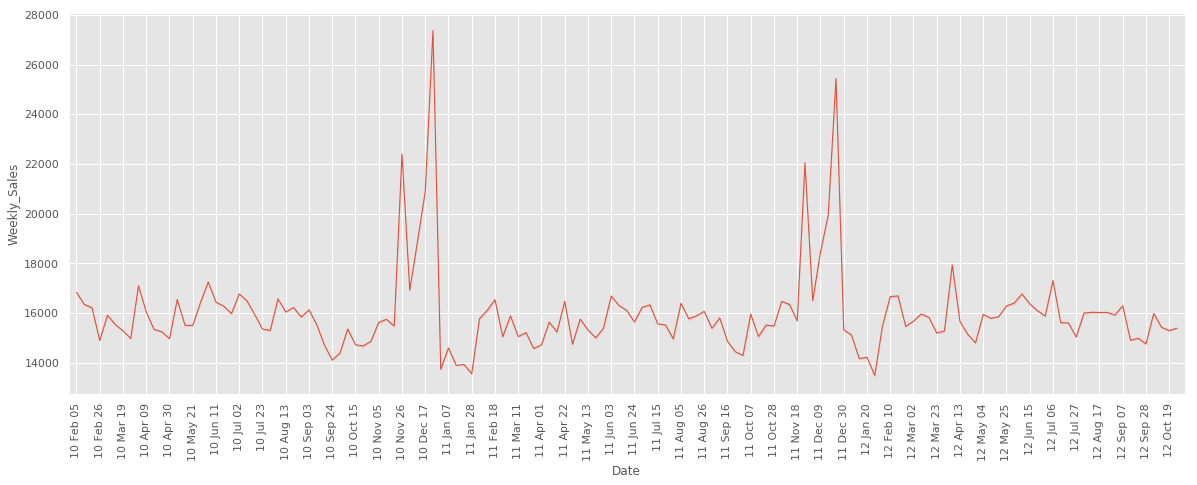

In [21]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20, 7))
sns.lineplot(x='Date', y='Weekly_Sales', data=df, linewidth=1, ci=5)
plt.xticks(rotation=90)
plt.xlim(df.Date.min()- timedelta(days=7), df.Date.max() + timedelta(days=7))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.FRIDAY, interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y %b %d'))
plt.show()

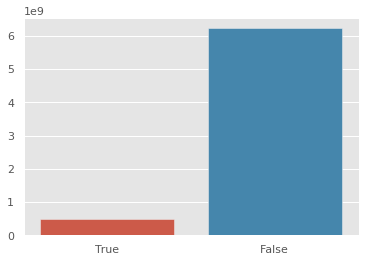

In [22]:
week_sales_list = [df['Weekly_Sales'][df['IsHoliday']==True].sum(),
                  df['Weekly_Sales'][df['IsHoliday']==False].sum()]
label = ['True', 'False']
sns.barplot(label, week_sales_list)

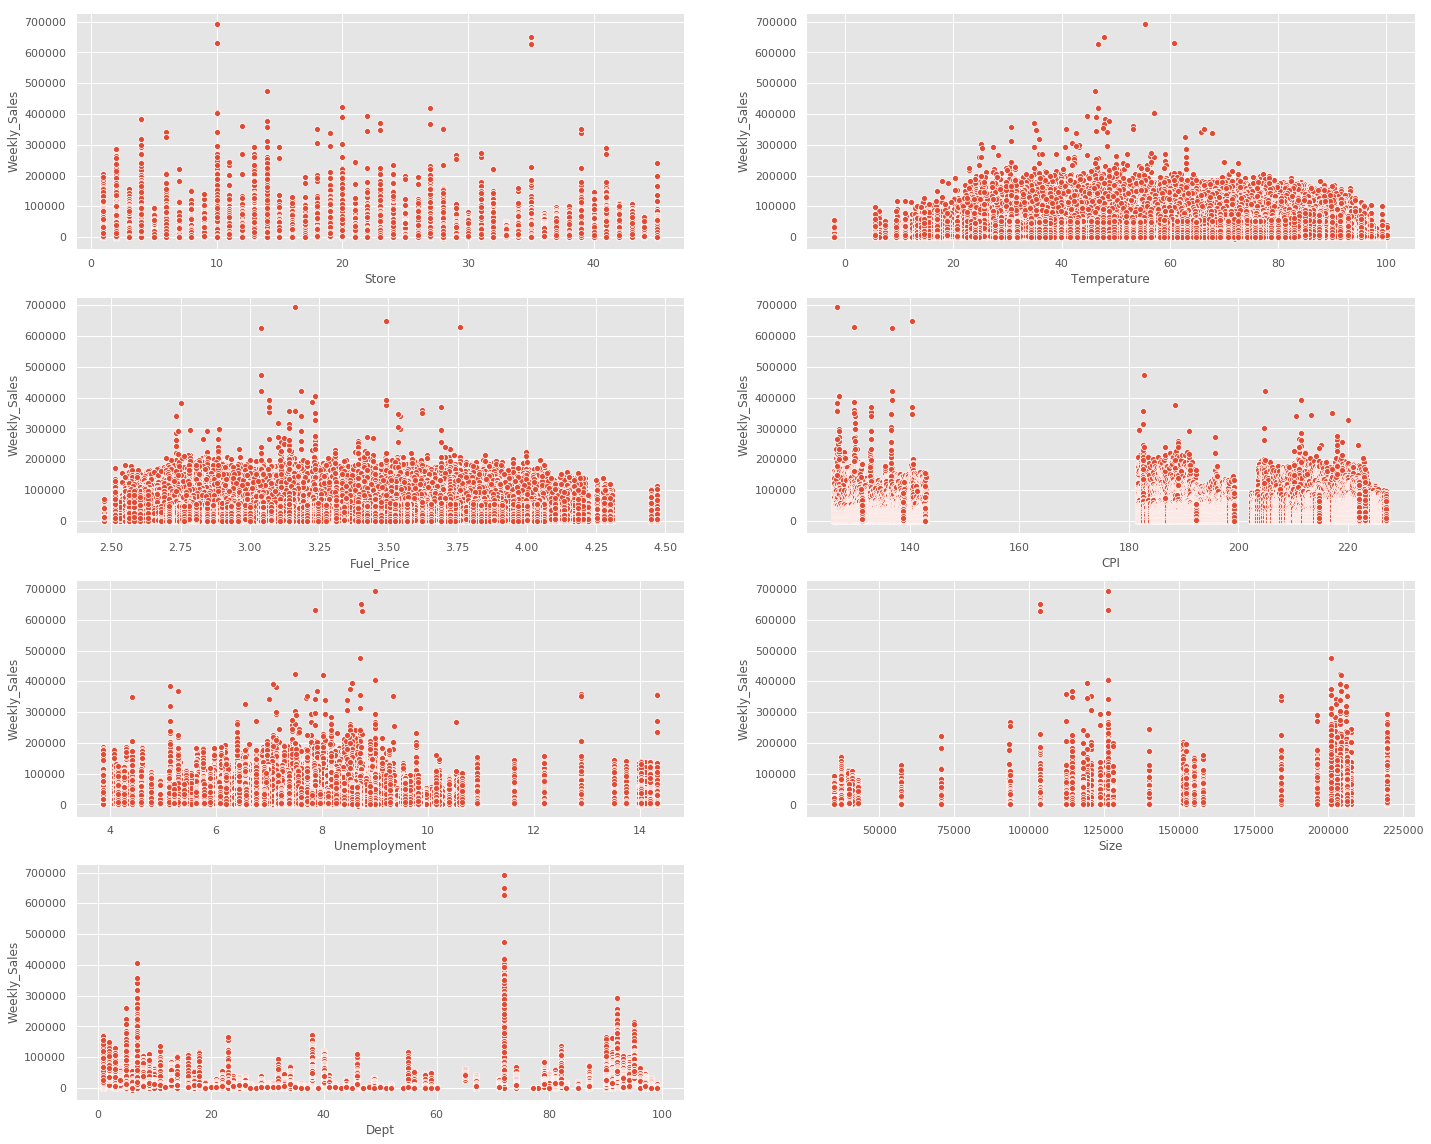

In [23]:
fig, ax = plt.subplots(4,2, figsize=(24, 20))
sns.scatterplot(x='Store', y='Weekly_Sales', data=df, ax=ax[0][0])
sns.scatterplot(x='Temperature', y='Weekly_Sales', data=df, ax=ax[0][1])
sns.scatterplot(x='Fuel_Price', y='Weekly_Sales', data=df, ax=ax[1][0])
sns.scatterplot(x='CPI', y='Weekly_Sales', data=df, ax=ax[1][1])
sns.scatterplot(x='Unemployment', y='Weekly_Sales', data=df, ax=ax[2][0])
sns.scatterplot(x='Size', y='Weekly_Sales', data=df, ax=ax[2][1])
sns.scatterplot(x='Dept', y='Weekly_Sales', data=df, ax=ax[3][0])
fig.delaxes(ax[3][1])
plt.show()

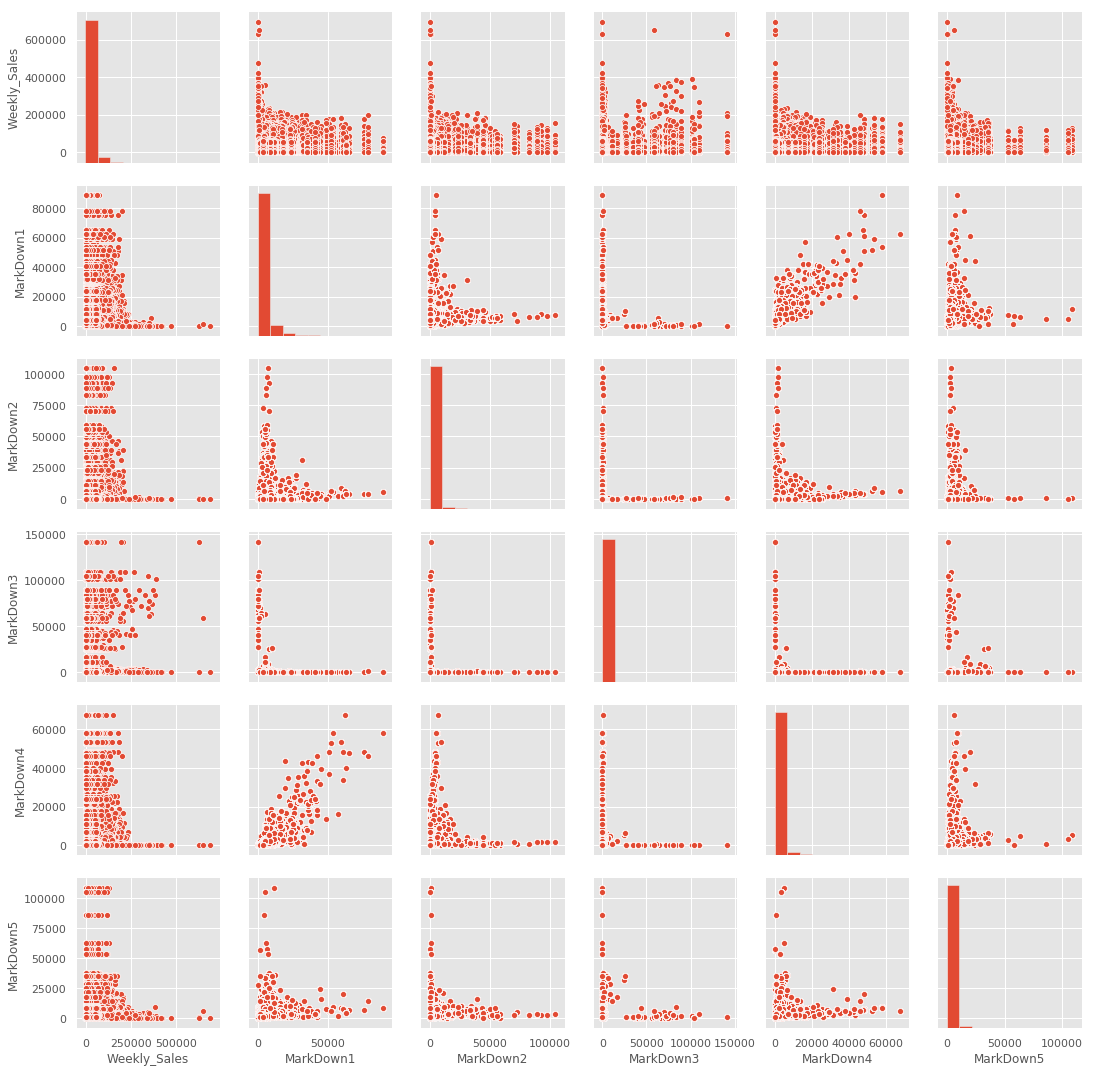

In [24]:
sns.pairplot(df, vars=['Weekly_Sales', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'])

In [25]:
cor = df.corr()
mask = np.zeros_like(cor)
mask[np.triu_indices_from(mask)] = True

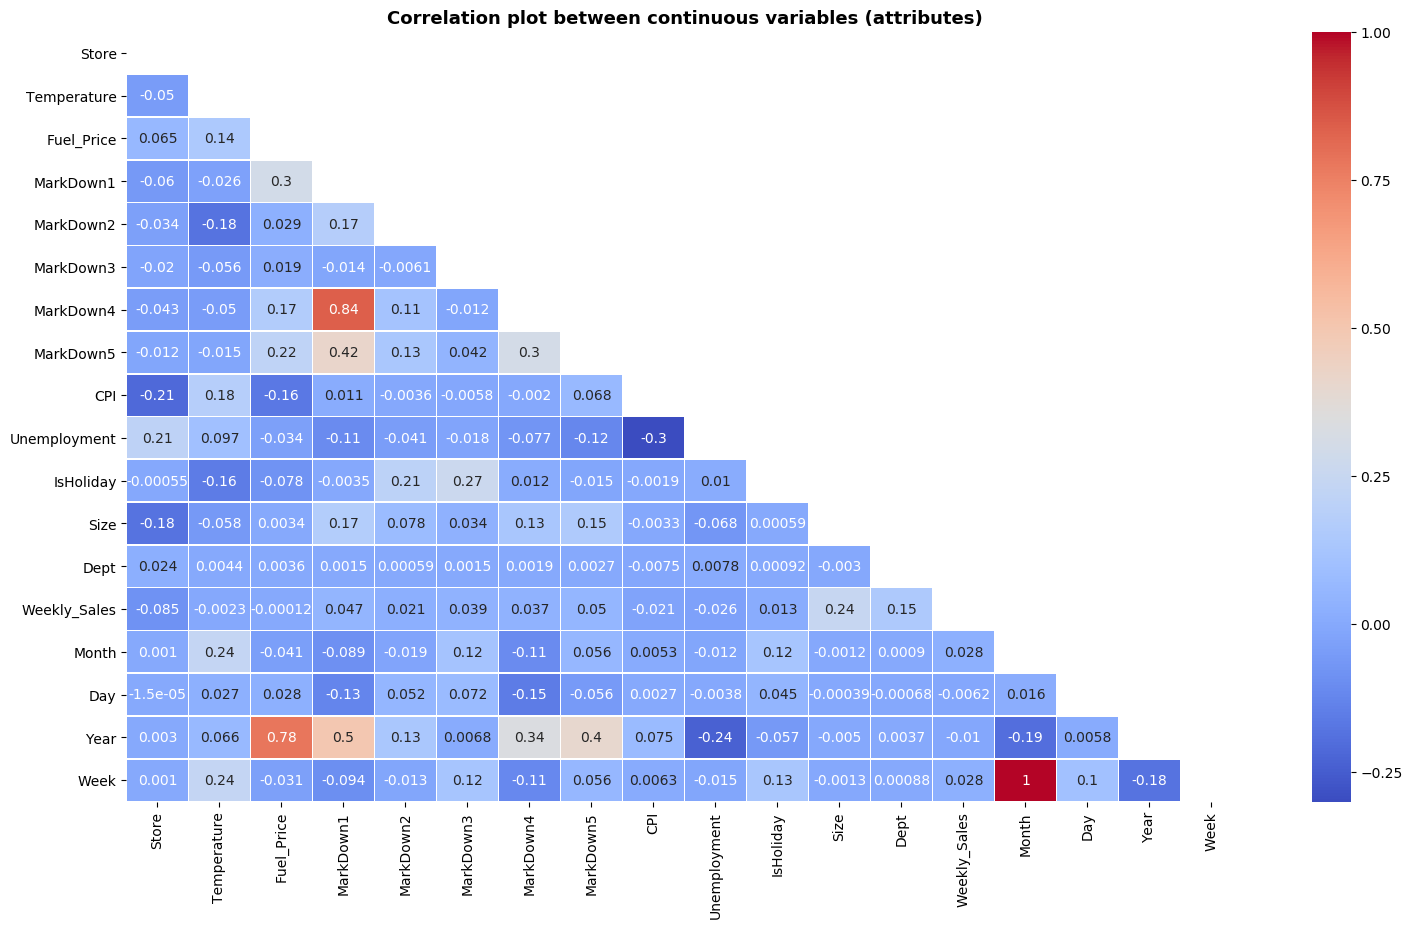

In [26]:
plt.style.use('default')
plt.figure(figsize=(18,10))
sns.axes_style("white")
sns.heatmap(cor, annot=True, cmap="coolwarm", mask = mask, linewidths=.5)
plt.title('Correlation plot between continuous variables (attributes)', size=13, fontweight='bold')
plt.show()

In [27]:
df_2010 = df[df.Year==2010]['Weekly_Sales'].groupby(df['Week']).mean()
df_2011 = df[df.Year==2011]['Weekly_Sales'].groupby(df['Week']).mean()
df_2012 = df[df.Year==2012]['Weekly_Sales'].groupby(df['Week']).mean()

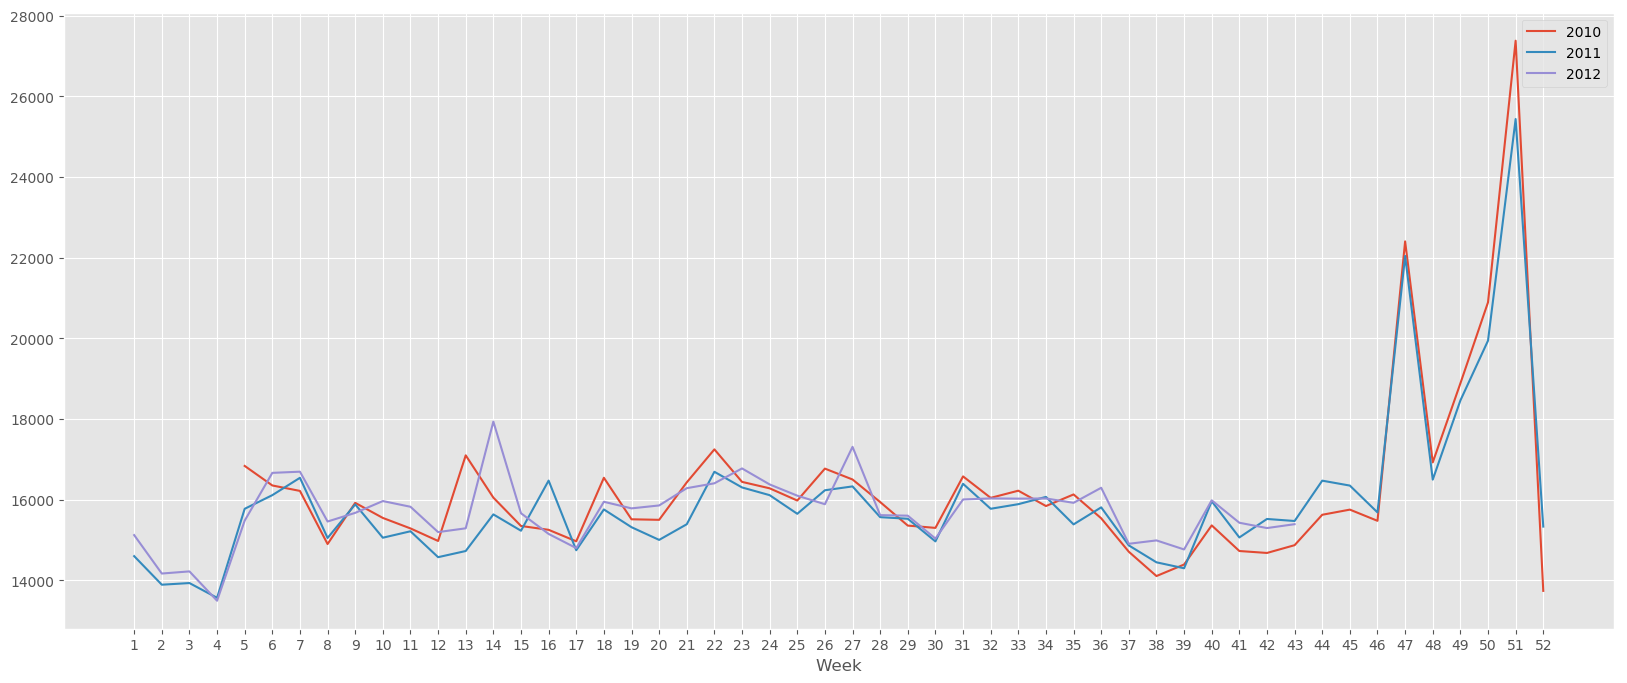

In [28]:
plt.style.use('ggplot')
plt.figure(figsize=(20,8))
sns.lineplot(df_2010.index, df_2010.values)
sns.lineplot(df_2011.index, df_2011.values)
sns.lineplot(df_2012.index, df_2012.values)
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best')
plt.show()

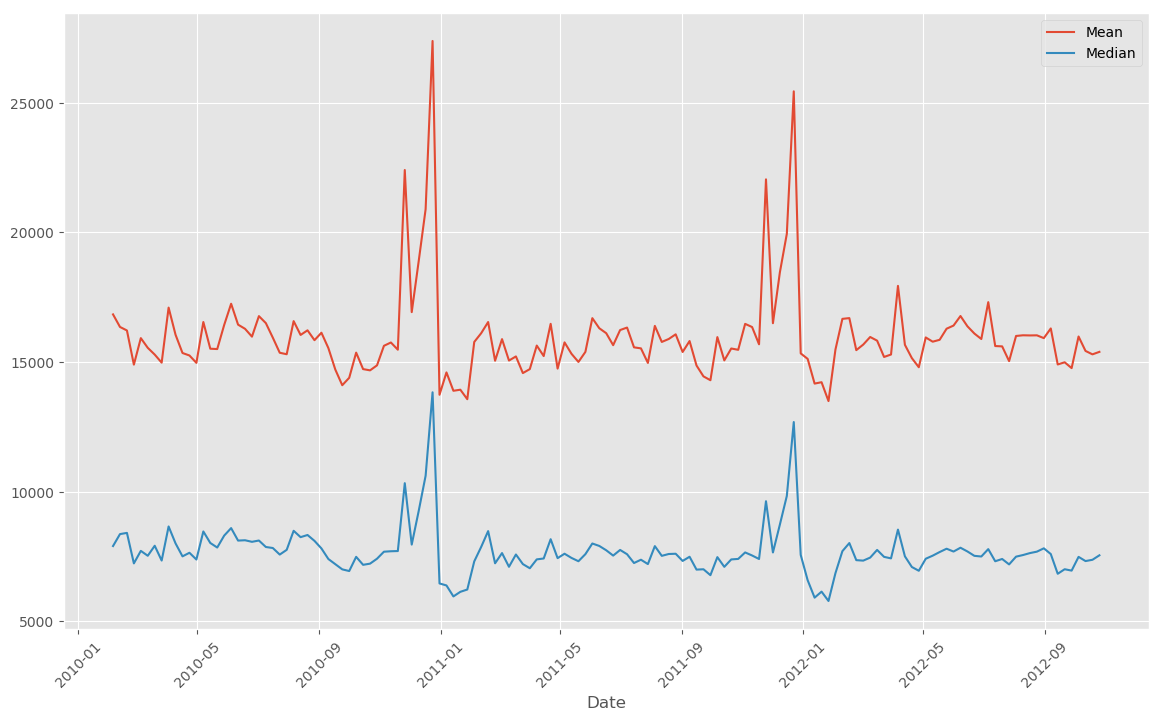

In [29]:
plt.figure(figsize=(14,8))
df_mean = df['Weekly_Sales'].groupby(df['Date']).mean()
df_median = df['Weekly_Sales'].groupby(df['Date']).median()
sns.lineplot(df_mean.index, df_mean.values)
sns.lineplot(df_median.index, df_median.values)
plt.legend(['Mean', 'Median'], loc='best')
plt.xticks(rotation=45)
plt.show()

## Feature Engineering

In [30]:
sca_var = list(df.select_dtypes(exclude=['object', 'bool', 'datetime64[ns]']).columns)
sca_var.remove('Weekly_Sales')
sca_var

['Store',
 'Temperature',
 'Fuel_Price',
 'MarkDown1',
 'MarkDown2',
 'MarkDown3',
 'MarkDown4',
 'MarkDown5',
 'CPI',
 'Unemployment',
 'Size',
 'Dept',
 'Month',
 'Day',
 'Year',
 'Week']

In [31]:
def cor_with_skew(feat):
    print('BoxCox 0.25\n' + 'Corr: ' + str(np.round(df['Weekly_Sales'].corr(boxcox1p(df[feat], 0.25)),2)) + ', Skew: ' + str(np.round(skew(boxcox1p(df[feat], 0.25), nan_policy='omit'),2)), '\n\n')
    print('BoxCox 0.15\n' + 'Corr: ' + str(np.round(df['Weekly_Sales'].corr(boxcox1p(df[feat], 0.15)),2)) + ', Skew: ' + str(np.round(skew(boxcox1p(df[feat], 0.15), nan_policy='omit'),2)), '\n\n')
    print('Linear\n' + 'Corr: ' + str(np.round(df['Weekly_Sales'].corr(df[feat]),2)) + ', Skew: ' + str(np.round(skew(df[feat], nan_policy='omit'),2)), '\n\n')
    sns.distplot(df[feat])
    plt.show()

Store  :- 
BoxCox 0.25
Corr: -0.08, Skew: -0.71 


BoxCox 0.15
Corr: -0.08, Skew: -0.84 


Linear
Corr: -0.09, Skew: 0.08 




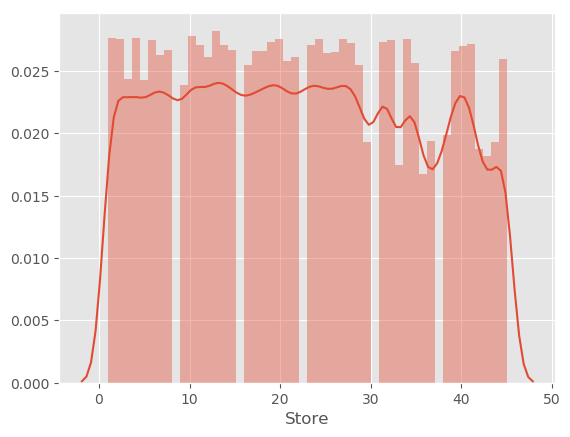

Temperature  :- 
BoxCox 0.25
Corr: 0.0, Skew: -0.92 


BoxCox 0.15
Corr: 0.0, Skew: -1.02 


Linear
Corr: -0.0, Skew: -0.32 




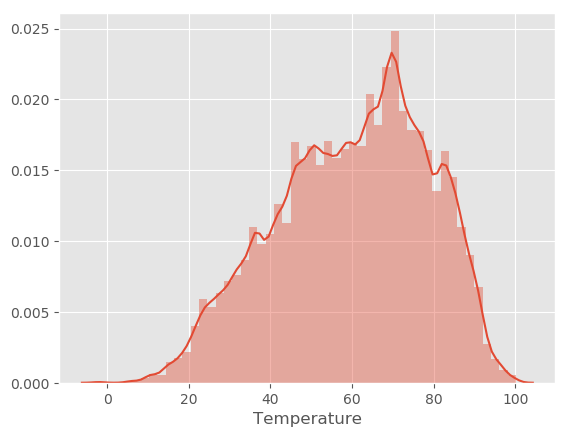

Fuel_Price  :- 
BoxCox 0.25
Corr: 0.0, Skew: -0.2 


BoxCox 0.15
Corr: 0.0, Skew: -0.21 


Linear
Corr: -0.0, Skew: -0.1 




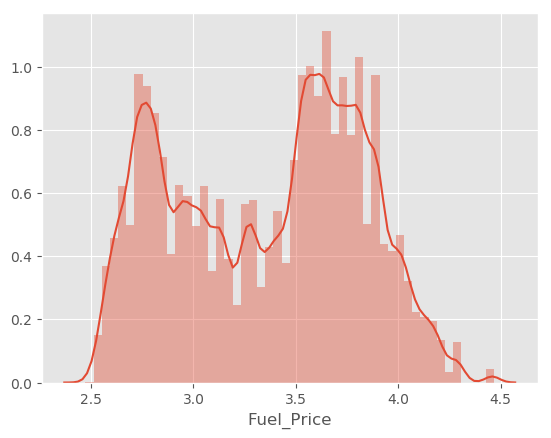

MarkDown1  :- 
BoxCox 0.25
Corr: 0.04, Skew: 1.03 


BoxCox 0.15
Corr: 0.03, Skew: 0.87 


Linear
Corr: 0.05, Skew: 4.73 




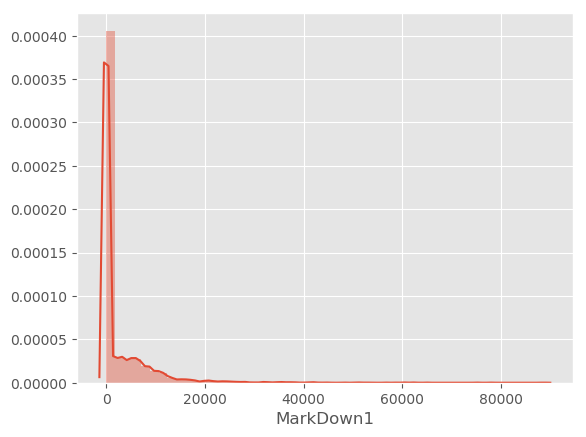

MarkDown2  :- 
BoxCox 0.25
Corr: 0.03, Skew: 2.98 


BoxCox 0.15
Corr: 0.03, Skew: 2.37 


Linear
Corr: 0.02, Skew: 10.65 




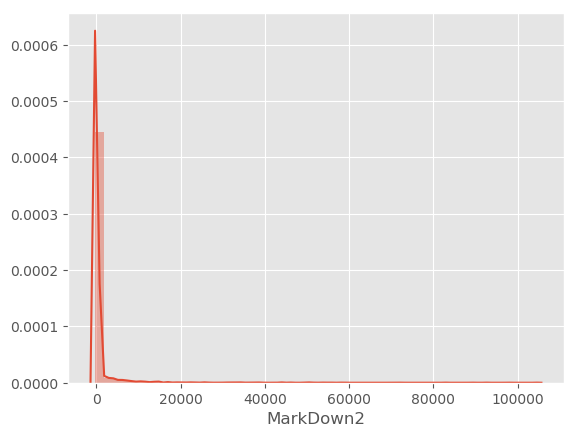

MarkDown3  :- 
BoxCox 0.25
Corr: 0.07, Skew: 5.95 


BoxCox 0.15
Corr: 0.07, Skew: 3.72 


Linear
Corr: 0.04, Skew: 14.92 




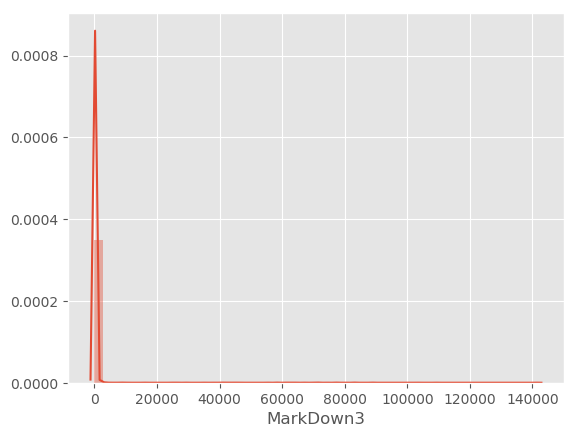

MarkDown4  :- 
BoxCox 0.25
Corr: 0.05, Skew: 1.53 


BoxCox 0.15
Corr: 0.05, Skew: 1.24 


Linear
Corr: 0.04, Skew: 8.08 




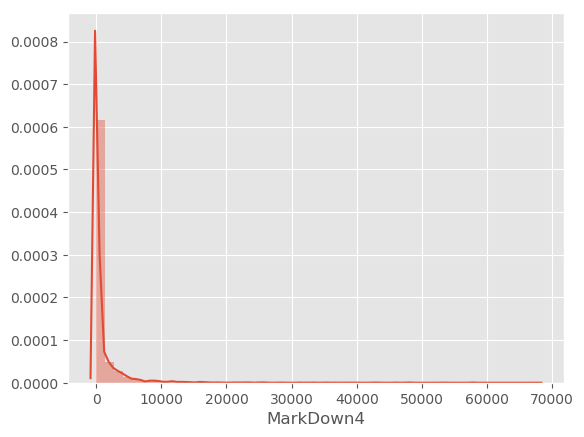

MarkDown5  :- 
BoxCox 0.25
Corr: 0.03, Skew: 0.89 


BoxCox 0.15
Corr: 0.03, Skew: 0.75 


Linear
Corr: 0.05, Skew: 9.96 




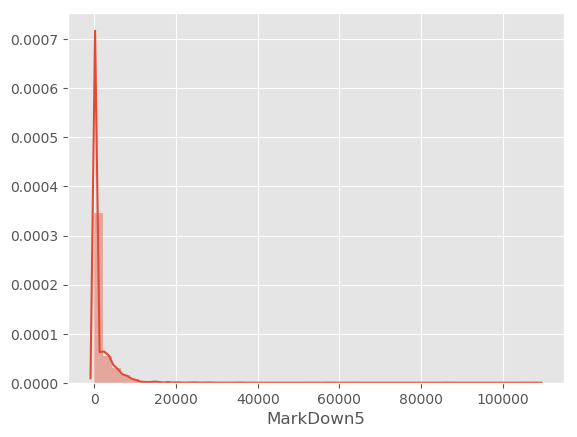

CPI  :- 
BoxCox 0.25
Corr: -0.02, Skew: 0.05 


BoxCox 0.15
Corr: -0.02, Skew: 0.04 


Linear
Corr: -0.02, Skew: 0.09 




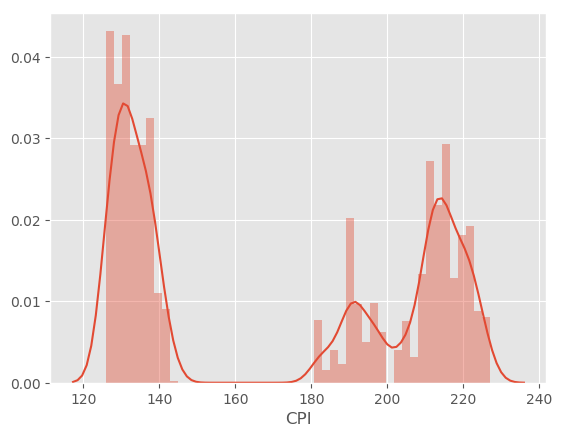

Unemployment  :- 
BoxCox 0.25
Corr: -0.03, Skew: 0.45 


BoxCox 0.15
Corr: -0.03, Skew: 0.35 


Linear
Corr: -0.03, Skew: 1.18 




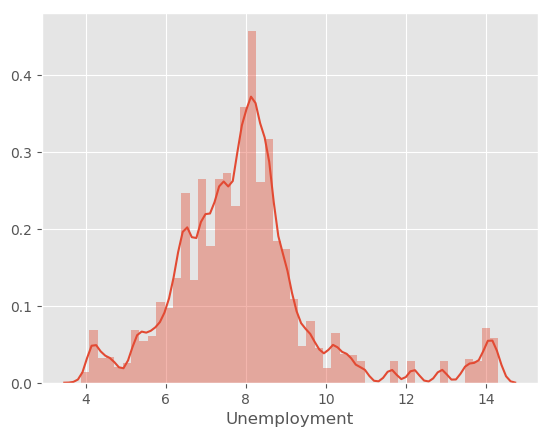

Size  :- 
BoxCox 0.25
Corr: 0.23, Skew: -0.77 


BoxCox 0.15
Corr: 0.23, Skew: -0.83 


Linear
Corr: 0.24, Skew: -0.33 




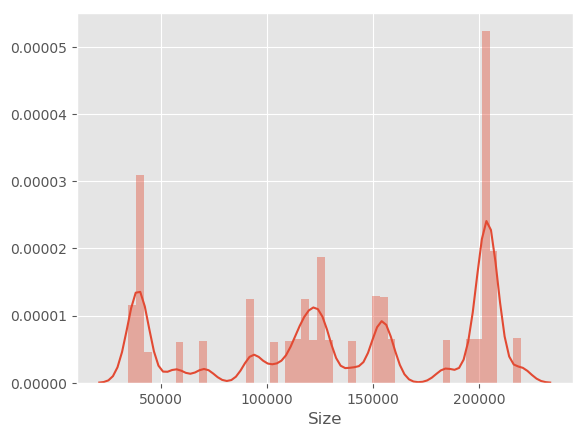

Dept  :- 
BoxCox 0.25
Corr: 0.06, Skew: -0.47 


BoxCox 0.15
Corr: 0.05, Skew: -0.63 


Linear
Corr: 0.15, Skew: 0.36 




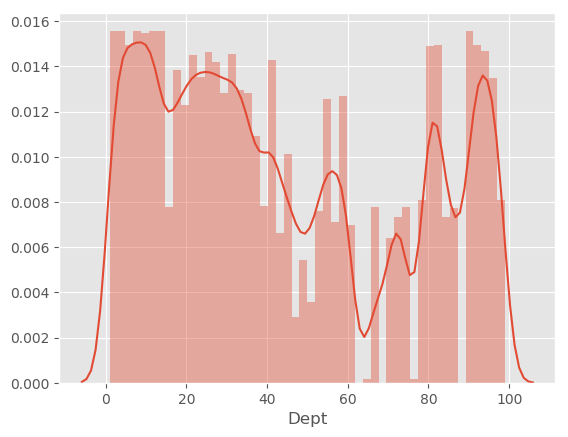

Month  :- 
BoxCox 0.25
Corr: 0.03, Skew: -0.49 


BoxCox 0.15
Corr: 0.03, Skew: -0.57 


Linear
Corr: 0.03, Skew: 0.04 




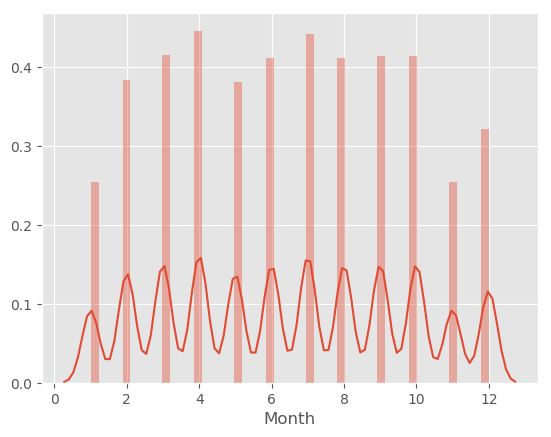

Day  :- 
BoxCox 0.25
Corr: -0.0, Skew: -0.67 


BoxCox 0.15
Corr: -0.0, Skew: -0.78 


Linear
Corr: -0.01, Skew: 0.01 




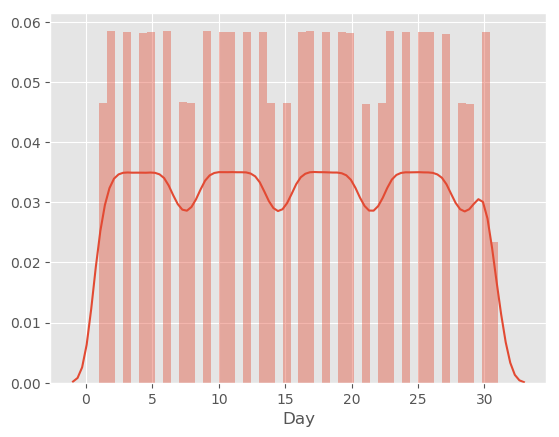

Year  :- 
BoxCox 0.25
Corr: -0.01, Skew: 0.06 


BoxCox 0.15
Corr: -0.01, Skew: 0.06 


Linear
Corr: -0.01, Skew: 0.06 




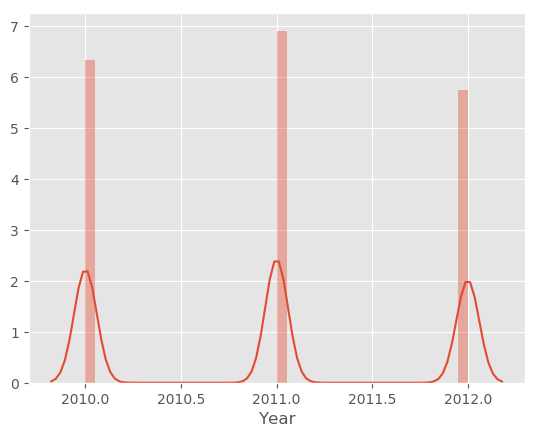

Week  :- 
BoxCox 0.25
Corr: 0.02, Skew: -0.74 


BoxCox 0.15
Corr: 0.02, Skew: -0.88 


Linear
Corr: 0.03, Skew: 0.05 




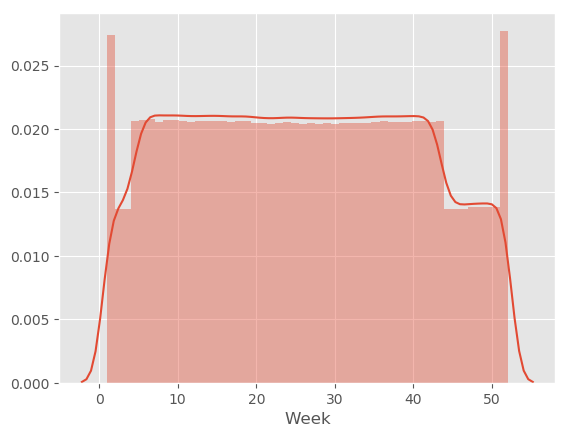

In [32]:
for name in sca_var:
    print(name, ' :- ')
    cor_with_skew(name)

In [33]:
df.drop(['Day','Year','Week','Temperature','Fuel_Price','MarkDown3','CPI','Unemployment','Date'],axis=1,inplace=True)

In [34]:
for j in df['Type'].unique():
    df['Type_'+j] = np.where(df['Type']==j, 1, 0)
df.drop('Type', axis=1, inplace=True)    
df.head()

,Store,MarkDown1,MarkDown2,MarkDown4,MarkDown5,IsHoliday,Size,Dept,Weekly_Sales,Month,Type_A,Type_B,Type_C
0,1,0.0,0.0,0.0,0.0,False,151315,1,24924.50,2,1,0,0
1,1,0.0,0.0,0.0,0.0,False,151315,2,50605.27,2,1,0,0
2,1,0.0,0.0,0.0,0.0,False,151315,3,13740.12,2,1,0,0
3,1,0.0,0.0,0.0,0.0,False,151315,4,39954.04,2,1,0,0
4,1,0.0,0.0,0.0,0.0,False,151315,5,32229.38,2,1,0,0


In [35]:
con_var = ['MarkDown1', 'MarkDown2', 'MarkDown4', 'MarkDown5', 'Size']
min_value = df[con_var].min().copy()
max_value = df[con_var].max().copy()
df[con_var] = (df[con_var] - min_value) / (max_value - min_value)
df.head()

,Store,MarkDown1,MarkDown2,MarkDown4,MarkDown5,IsHoliday,Size,Dept,Weekly_Sales,Month,Type_A,Type_B,Type_C
0,1,0.0,0.002536,0.0,0.0,False,0.630267,1,24924.50,2,1,0,0
1,1,0.0,0.002536,0.0,0.0,False,0.630267,2,50605.27,2,1,0,0
2,1,0.0,0.002536,0.0,0.0,False,0.630267,3,13740.12,2,1,0,0
3,1,0.0,0.002536,0.0,0.0,False,0.630267,4,39954.04,2,1,0,0
4,1,0.0,0.002536,0.0,0.0,False,0.630267,5,32229.38,2,1,0,0


## Model

In [36]:
train_df = df.sample(frac=0.8)
test_df = df.drop(train_df.index)

In [37]:
def train_and_report(model, df):
    kf = KFold(n_splits=5, shuffle=True)
    score = []
    for i in range(5):
        result = next(kf.split(df))
        train_x = df.iloc[result[0]].drop(columns=['Weekly_Sales'])
        train_y = df.iloc[result[0]]['Weekly_Sales']
        test_x = df.iloc[result[1]].drop(columns=['Weekly_Sales'])
        test_y = df.iloc[result[1]]['Weekly_Sales']
        res = model.fit(train_x, train_y)
        score.append(res.score(test_x, test_y))
    pred = model.predict(test_x)
    regression_report(test_y, pred)
    print('KFold Score:- ', sum(score) / len(score))

In [38]:
def regression_report(y_true, y_pred):
    print('Variance Score:- ', explained_variance_score(y_true, y_pred))
    print('Mean Absolute Error:- ', mean_absolute_error(y_true, y_pred))
    print('Mean Square Error:- ', mean_squared_error(y_true, y_pred))
    print('Mean Absolute Error:- ', median_absolute_error(y_true, y_pred))
    print('R2 Score:- ', r2_score(y_true, y_pred))

In [39]:
pf = PolynomialFeatures(degree=2)
df_poly = pf.fit_transform(df.drop(columns=['Weekly_Sales']))
df_poly_test = pf.transform(test_df.loc[:, test_df.columns != 'Weekly_Sales'])

In [40]:
kn = KNeighborsRegressor(n_neighbors=10)
rfr = RandomForestRegressor(n_estimators=100,max_features='log2')
lr = LinearRegression()
xgbr = XGBRegressor(max_depth=5, learning_rate=0.01, objective='reg:squarederror')

In [41]:
print('*******', 'LinearRegression with Polynomial features(degree=2)', '*******')
lr_poly = LinearRegression()
lr_poly.fit(df_poly, df['Weekly_Sales'])
pred = lr_poly.predict(df_poly_test)
regression_report(test_df['Weekly_Sales'], pred)

******* LinearRegression with Polynomial features(degree=2) *******
Variance Score:-  0.2174095786986444
Mean Absolute Error:-  12711.50092437338
Mean Square Error:-  406423943.98865956
Mean Absolute Error:-  8348.401249999999
R2 Score:-  0.2174023009342999


In [42]:
model_list = [kn, rfr, lr, xgbr]
for model in model_list:
    print("*******", type(model).__name__, "*******")
    train_and_report(model, df)
    print()

******* KNeighborsRegressor *******
Variance Score:-  0.9080781169689274
Mean Absolute Error:-  2811.5571491567234
Mean Square Error:-  49777007.60067772
Mean Absolute Error:-  1023.2660000000001
R2 Score:-  0.9080744416167523
KFold Score:-  0.9099041558292275

******* RandomForestRegressor *******
Variance Score:-  0.8599285753849708
Mean Absolute Error:-  4010.4695994555186
Mean Square Error:-  72374532.34136692
Mean Absolute Error:-  1413.9493636327516
R2 Score:-  0.8599188517615003
KFold Score:-  0.856343437590642

******* LinearRegression *******
Variance Score:-  0.08701100767229519
Mean Absolute Error:-  14530.526278212988
Mean Square Error:-  463731355.5246444
Mean Absolute Error:-  11099.563750000001
R2 Score:-  0.08700640069156584
KFold Score:-  0.08696544339841286

******* XGBRegressor *******
Variance Score:-  0.5261437933195211
Mean Absolute Error:-  8880.30246164946
Mean Square Error:-  277880039.824564
Mean Absolute Error:-  4173.613388671875
R2 Score:-  0.46131569875142